In [ ]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os
import statistics

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.preprocessing as prep
import src.models as models
import src.losses as loss

from keras import backend as K

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [2]:
use_colab = False

if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset"

In [4]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset()
ska_dataset.load_dataset() #TODO: spostare nel costruttore

Dataset shape: (274883, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,19583869,-0.027182,-29.880180,-0.025817,-29.881346,3.071800e-05,0.007015,242.875,124.447,19.617,1,1,1,16516.367,17089.901
1,2200269,-0.311221,-29.578638,-0.311221,-29.578638,3.354310e-08,-0.000000,255.579,85.189,25.461,1,1,1,17995.551,18891.185
2,20370953,-0.156639,-29.613901,-0.156022,-29.610902,5.051040e-08,0.013133,157.013,135.343,15.008,1,1,1,17191.154,18700.606
3,3922693,-0.568954,-29.680477,-0.567827,-29.677515,7.818010e-08,0.000487,66.171,57.413,270.983,1,1,1,19322.199,18297.016
4,22627893,-0.100985,-29.692011,-0.100985,-29.692011,3.785790e-08,-0.000000,346.540,180.875,310.391,1,1,1,16905.655,18217.704


In [6]:
ska_dataset.load_train_image() #TODO: spostare nel costruttore

Loading FITS file c:\Users\alice\Desktop\universita_AI\deep_learning\SKADC1\data\training\560Mhz_1000h.fits


### Preprocessing

In [ ]:
img_box = ska_dataset.cleaned_snr_df[ x1 -ska_dataset.x_origin: x2 - ska_dataset.x_origin ,y1 - ska_dataset.y_origin : y2 -ska_dataset.x_origin ].copy()


In [21]:
ska_dataset.process_dataset() #TODO: spostare nel costruttore
#coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header )

100%|██████████| 190553/190553 [00:39<00:00, 4852.96it/s]


Initial dataset shape: (190553, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (190553, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (190553, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


In [31]:
df_train = ska_dataset.cleaned_train_df[['x', 'y', 'x1', 'y1']]
df_train.shape
df_train.head()

,x,y,x1,y1
0,16516.367,17089.901,16277.496963,16943.219269
1,17995.551,18891.185,17755.565821,18753.408716
2,17191.154,18700.606,17031.265330,18559.970425
3,19322.199,18297.016,19263.171617,18229.007654
4,16905.655,18217.704,16635.064265,17921.080583


In [9]:
df_train[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,190553.000000,190553.000000,190553.000000,190553.000000
mean,6.079408,6.068805,115.419109,115.419109
std,9.274887,9.212232,3003.355774,3003.355774
min,4.964839,4.964839,24.649628,24.649628
25%,4.979843,4.979872,24.819117,24.819117
50%,5.007610,5.007551,25.116861,25.116861
75%,5.109774,5.110085,26.222960,26.222960
max,790.278778,891.344479,498215.442679,498215.442679


In [37]:
type(ska_dataset.data_560Mhz_1000h_train)
ska_dataset.data_560Mhz_1000h_train.shape
print(list(ska_dataset.cleaned_train_df.columns))


['ID', 'RA (core)', 'DEC (core)', 'RA (centroid)', 'DEC (centroid)', 'FLUX', 'Core frac', 'BMAJ', 'BMIN', 'PA', 'SIZE', 'CLASS', 'SELECTION', 'x', 'y', 'x1', 'y1', 'x2', 'y2', 'major_semia_px', 'minor_semia_px', 'pa_in_rad', 'width', 'height', 'area_orig', 'area_cropped', 'HighSTD']


database len 190553
min x val = 16120
min y val = 16567
x len = 3879
y len = 3464
max val = 0.006585681
-2.5757961390339505e-14 4.4985624470319427e-07
(3464, 3879)
190553
list length 190553
4576
new df 4576


(3464, 3879)

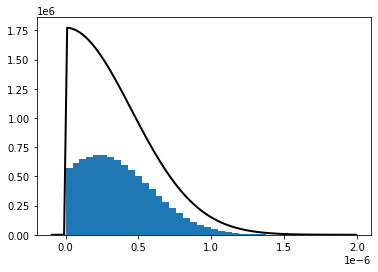

In [54]:
plot_Noise_Hist = False
ska_dataset.cut_preprocess_image(plot_Noise_Hist)
ska_dataset.data_560Mhz_1000h_train.shape

0.0 0.0 0.0


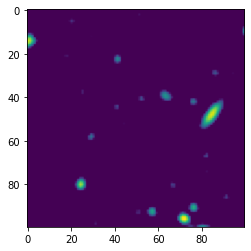

In [20]:
from astropy.stats import sigma_clipped_stats
i = 0#16120
j = 0#16567
patch_dim = 100
img = ska_dataset.training_image[i:i+patch_dim, j:j+patch_dim].copy()
plt.imshow(img, cmap='viridis')
mean, median, std = sigma_clipped_stats(img, sigma=3.0)#, iter=5)
print(mean, median, std)

In [12]:
show_plot = False
ska_dataset.generate_patches(limit=1, plot_patches=show_plot) # Remember to remove internal return

  0%|          | 0/64 [00:00<?, ?it/s]Patch 0_16376_16729_100 saved
Patch 50_16426_16729_100 saved
  2%|▏         | 1/64 [00:01<01:49,  1.73s/it]Patch 100_16476_16729_100 saved
Patch 1550_16376_16779_100 saved
Patch 1600_16426_16779_100 saved
  3%|▎         | 2/64 [00:03<01:47,  1.73s/it]Patch 1650_16476_16779_100 saved
Patch 3100_16376_16829_100 saved
Patch 3150_16426_16829_100 saved
100%|██████████| 64/64 [00:05<00:00, 12.59it/s]Patch 3200_16476_16829_100 saved
['1_1' '2_1' '3_1']
3



number of possible class combinations: 7


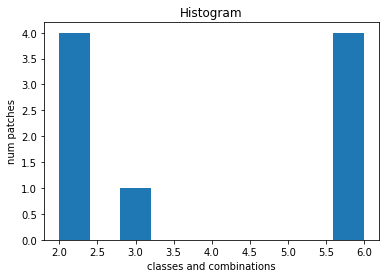

In [13]:
ska_dataset.analyze_class_distribution()

In [14]:
ska_dataset.split_train_val_stratification(random_state=42, val_portion=0.2)

print(len(ska_dataset.train_patch_list))
print(len(ska_dataset.val_patch_list))


key_1 not splitted
key_3 not splitted
key_4 not splitted
key_5 not splitted
key_7 not splitted
split ended
6
2


len of class: 2 4
len of common ID: 3
len of class: 3 1
len of common ID: 1
len of class: 6 4
len of common ID: 3


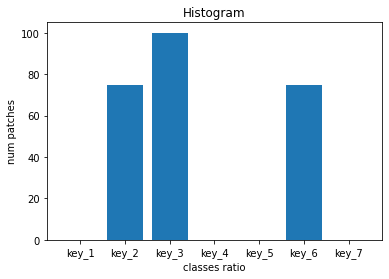

In [15]:
ska_dataset.split_train_val(random_state=42, val_portion=0.2)

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

### Get FRCNN model

In [43]:
# Choose the feature extraction model

backbone='resnet50'


In [44]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

______________
bn3b_branch2a (BatchNormalizati (None, 75, 75, 128)  512         res3b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 75, 75, 128)  0           bn3b_branch2a[0][0]              
__________________________________________________________________________________________________
res3b_branch2b (Conv2D)         (None, 75, 75, 128)  147584      activation_53[0][0]              
__________________________________________________________________________________________________
bn3b_branch2b (BatchNormalizati (None, 75, 75, 128)  512         res3b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 75, 75, 128)  0           bn3b_branch2b[0][0]              
______________________________________________________________________________________________

### Load weights

In [45]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

Download completed!


In [25]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [19]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

In [46]:
from src.train import *
val_patch_list = None
train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, ska_dataset.val_patch_list, ska_dataset.class_list, num_epochs=1, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=False)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

# Validation

In [20]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

____________
activation_13 (Activation)      (None, 75, 75, 128)  0           bn3b_branch2a[0][0]              
__________________________________________________________________________________________________
res3b_branch2b (Conv2D)         (None, 75, 75, 128)  147584      activation_13[0][0]              
__________________________________________________________________________________________________
bn3b_branch2b (BatchNormalizati (None, 75, 75, 128)  512         res3b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 75, 75, 128)  0           bn3b_branch2b[0][0]              
__________________________________________________________________________________________________
res3b_branch2c (Conv2D)         (None, 75, 75, 512)  66048       activation_14[0][0]              
________________________________________________________________________________________________

In [21]:
# Models used for mAP eval
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=0)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [42]:
# Spostare in una funzione "evaluate model" che fa la predict su tutte le img di validation e calcola il map
patch_id = ska_dataset.train_patch_list[48:50]
print(patch_id)
gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
display(gt['class_label'])

preds, mAP, prec, recall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, patch_id, ska_dataset.class_list)

print(preds)

['26350_16376_17579_100', '26400_16426_17579_100']


0     2_1
1     2_1
2     2_1
3     2_1
4     3_1
5     2_1
6     2_1
7     2_1
8     2_1
9     2_1
10    2_1
11    2_1
12    2_1
13    2_1
14    2_1
15    2_1
16    2_1
Name: class_label, dtype: object

Predict
rpn_to_roi
(1, 38, 38, 15)
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:326: RuntimeWarning: overflow encountered in exp
  y1 = cy1 - h1/2.
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:155: RuntimeWarning: invalid value encountered in add
  # with warnings.catch_warnings():
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:325: RuntimeWarning: overflow encountered in exp
  x1 = cx1 - w1/2.
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:154: RuntimeWarning: invalid value encountered in add
  
Elapsed:14.6375572681427
Predict
rpn_to_roi
(1, 38, 38, 15)
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/utils.py:326: RuntimeWarning: overflow encountered in exp
  y1 = cy1 - h1/2.
/Users/lorenzocellini/AI - Universit…/Deep Learning - 

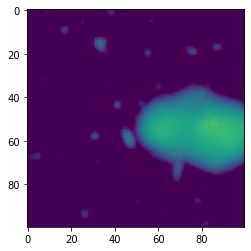

In [52]:
print_img(config.TRAIN_PATCHES_FOLDER, '0_16376_16729_100')

In [266]:
anch = pd.read_pickle(f'{config.EVAL_RESULTS}/{patch_id[0]}/{patch_id[0]}.pkl')

In [267]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [268]:
anch.describe() 

,x1s,y1s,x2s,y2s,class,prob,width,heght
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [x] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [x] implementare resNet50
- [x] implementare predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [x] provare campionamento random patch ed osservare le due distribuzioni - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [x] Riscalare immagini tra 0-255 - Alice
- [x] capire se passare tre immagini diverse come input
- [x] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [x] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [ ] rifattorizzare classe dataset spostando nel costruttore i metodi che calcolano i suoi attributi - Lorenzo
- [x] chek valori pixel in input per resnet
- [x] fare funzione per plottare le predictions
- [ ] trainare tutto su colab

TODO - 20210714
- [x] ragionare su come scalare le immagini fra 0 e 1, attualmente hanno tanti valori schiacciati a 0 e il massimo su tutto il train a a 0.4

TODO - 20210717
- [ ] Ablation study: provare a rimuovere stage4 nella resnet - se c'è tempo
- [x] Provare con nostra pixel_mean e con vgg16 pixel_mean -> per il momento abbiamo scartato la prima opzione
- [ ] Fare qualche analisi di distribuzione delle classi/dim box del dataset - Alice
- [x] Aggiungere normalizzazione dopo zero centering per resNet50, sulla base del range globale dell'immagine di training
- [ ] Provare pulizia dataset originale sulla base del rumore/flusso - Alice
- [ ] Cambiare nomi di tutto - alla fine
- [x] implementare zero-centering su volare medio RGB delle nostre patch
- [ ] Funzione che trova l'ultimo checkpoint in colab prima del load_weights - Lorenzo

# Plotting

In [253]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

(32, 5)


In [245]:
loss_history

array([[2.21167493e+00, 5.48505938e+01, 1.41033335e+01, 9.02264648e+02,
        1.25000000e-01],
       [3.47529209e+00, 6.21291500e+00, 1.20885715e+01, 2.05328012e+00,
        2.50000000e-01],
       [3.08124007e+00, 4.84355471e+00, 8.05904770e+00, 2.38956679e+01,
        5.00000000e-01],
       [2.60109515e+00, 1.80010146e+00, 6.68381833e+00, 1.44240359e+01,
        4.75000000e-01],
       [3.40300663e+00, 1.71771869e+00, 8.33843269e+00, 1.56928931e+01,
        4.50000000e-01],
       [3.16217673e+00, 5.52144847e-01, 8.05904770e+00, 3.37423466e+01,
        5.00000000e-01],
       [3.15954884e+00, 2.11416296e-01, 2.44386007e+00, 1.61016402e+00,
        5.25000000e-01],
       [4.03812165e+00, 1.64660653e-01, 7.46127805e-01, 4.78080065e-01,
        5.50000000e-01],
       [3.41979742e+00, 1.61025919e-01, 9.01550260e-01, 6.71743631e-01,
        4.50000000e-01],
       [2.56015201e+00, 1.47500894e-01, 7.04970554e-01, 4.51246776e-01,
        6.00000000e-01],
       [2.21090159e+00, 1.3848

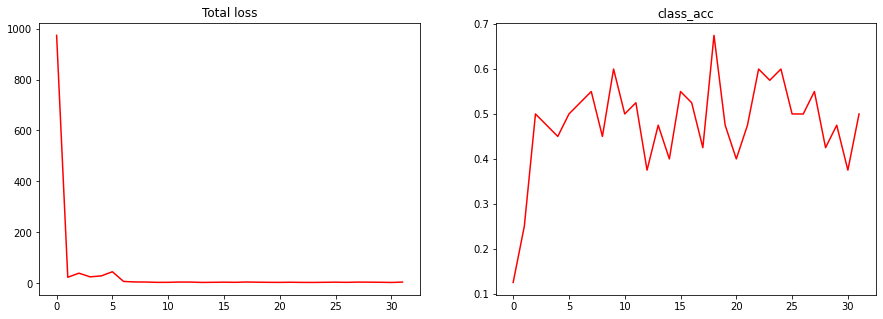

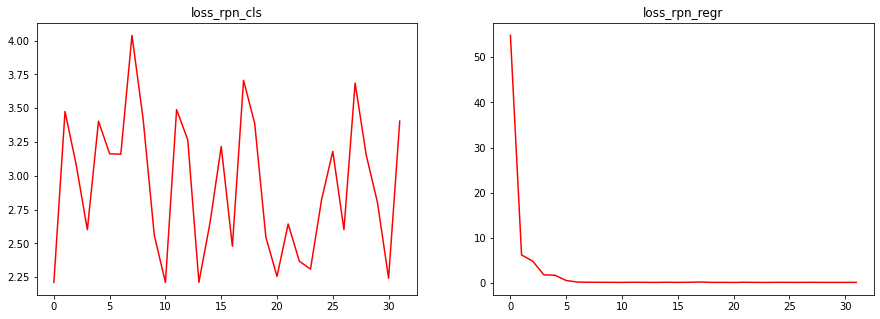

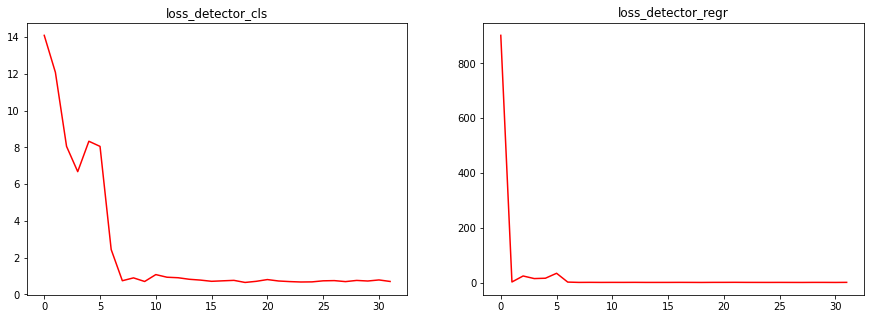

In [256]:
plot_loss(loss_history)

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')